<a href="https://colab.research.google.com/github/intel-analytics/BigDL/blob/branch-2.0/python/orca/colab-notebook/quickstart/tf_lenet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


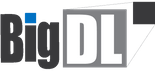
---

##### Copyright 2016 The BigDL Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install BigDL Orca**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca

In [ ]:
# Install required dependencies
!pip install tensorflow==1.15.0 tensorflow-datasets==2.1.0

## **Distributed TensorFlow (v1.15) using Orca APIs**

In this guide we will describe how to scale out TensorFlow (v1.15) programs using Orca in 4 simple steps.

In [ ]:
# import necesary libraries and modules
import argparse

from bigdl.orca.learn.tf.estimator import Estimator
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context** 

In [ ]:
OrcaContext.log_output = True # recommended to set it to True when running BigDL in Jupyter notebook (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=4) # run in local mode
    dataset_dir = "~/tensorflow_datasets"
elif cluster_mode == "k8s":  
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=2) # run on K8s cluster
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2) # run on Hadoop YARN cluster
    dataset_dir = "hdfs:///tensorflow_datasets

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 2: Define the Model**

You may define your model, loss and metrics in the same way as in any standard (single node) TensorFlow program.

In [ ]:
import tensorflow as tf

def accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1, output_type=labels.dtype)
  is_correct = tf.cast(tf.equal(predictions, labels), dtype=tf.float32)
  return tf.reduce_mean(is_correct)


def lenet(images):
  with tf.variable_scope('LeNet', [images]):
    net = tf.layers.conv2d(images, 32, (5, 5), activation=tf.nn.relu, name='conv1')
    net = tf.layers.max_pooling2d(net, (2, 2), 2, name='pool1')
    net = tf.layers.conv2d(net, 64, (5, 5), activation=tf.nn.relu, name='conv2')
    net = tf.layers.max_pooling2d(net, (2, 2), 2, name='pool2')
    net = tf.layers.flatten(net)
    net = tf.layers.dense(net, 1024, activation=tf.nn.relu, name='fc3')
    logits = tf.layers.dense(net, 10)
    return logits

# tensorflow inputs
images = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1))
# tensorflow labels
labels = tf.placeholder(dtype=tf.int32, shape=(None,))

logits = lenet(images)

loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels))

acc = accuracy(logits, labels)

### **Step 3: Define Train Dataset**

In [8]:
import tensorflow_datasets as tfds

def preprocess(data):
  data['image'] = tf.cast(data["image"], tf.float32) / 255.
  return data['image'], data['label']

In [ ]:
# get DataSet
mnist_train = tfds.load(name="mnist", split="train", data_dir=dataset_dir)
mnist_test = tfds.load(name="mnist", split="test", data_dir=dataset_dir)

mnist_train = mnist_train.map(preprocess)
mnist_test = mnist_test.map(preprocess)

### **Step 4: Fit with Orca Estimator**

First, create an Estimator.



In [ ]:
est = Estimator.from_graph(inputs=images,
                           outputs=logits,
                           labels=labels,
                           loss=loss,
                           optimizer=tf.train.AdamOptimizer(),
                           metrics={"acc": acc})

Next, fit the Estimator.

In [ ]:
max_epoch = 1
est.fit(data=mnist_train,
        batch_size=320,
        epochs=max_epoch,
        validation_data=mnist_test)

Finally, evaluate using the Estimator.

In [ ]:
result = est.evaluate(mnist_test)
print(result)

est.save_tf_checkpoint("/tmp/lenet/model")

Now, the accuracy of this model has reached 98%.

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()